In [1]:
from collections import defaultdict, Counter
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn
import pandas as pd
%matplotlib inline
seaborn.set_style("whitegrid")

In [2]:
TRIALS_CSV = "results/debug/trialdata.csv"
trials = pd.read_csv(TRIALS_CSV, header=None, names=["user_id", "trial_id", "time", "trial_data"])
trials.head()

,user_id,trial_id,time,trial_data
0,debugHP1B1C:debugIQ1RBC,0,1520971377501,"{""rt"": 1509, ""trial_type"": ""instructions"", ""vi..."
1,debugHP1B1C:debugIQ1RBC,1,1520971379276,"{""rt"": 1774, ""trial_type"": ""survey-text"", ""res..."
2,debugHP1B1C:debugIQ1RBC,2,1520971382775,"{""rt"": 3490, ""trial_type"": ""survey-multi-choic..."
3,debugHP1B1C:debugIQ1RBC,3,1520971383777,"{""rt"": null, ""trial_type"": ""html-keyboard-resp..."
4,debugHP1B1C:debugIQ1RBC,4,1520971388394,"{""rt"": 4614, ""trial_type"": ""scene-choice"", ""pr..."


## Demographics

In [3]:
users = defaultdict(dict)
for i, trial in trials.iterrows():
    tdata = json.loads(trial.trial_data)
    try:
        responses = json.loads(tdata["responses"])
    except KeyError:
        continue
        
    user_data = users[trial.user_id]
    if tdata["trial_type"] == "survey-text":
        if tdata["trial_index"] == 1:
            user_data["age"] = int(responses["Q0"])
        else:
            user_data["comments"] = responses["Q0"]
    elif tdata["trial_type"] == "survey-multi-choice":
        user_data["sex"] = responses["Q0"]
        user_data["education"] = responses["Q1"]
        user_data["native"] = responses["Q2"]
        
users = pd.DataFrame.from_dict(users, "index")
users.head()

,age,sex,education,native,comments
debugHP1B1C:debugIQ1RBC,3,Male,Did not complete high school,Yes,v


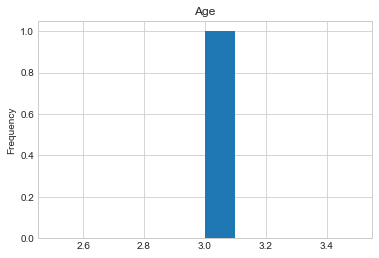

In [4]:
users.age.plot.hist(title="Age")

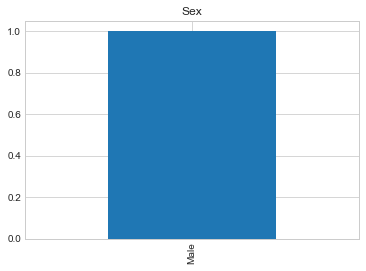

In [5]:
users.sex.value_counts().plot.bar(title="Sex")

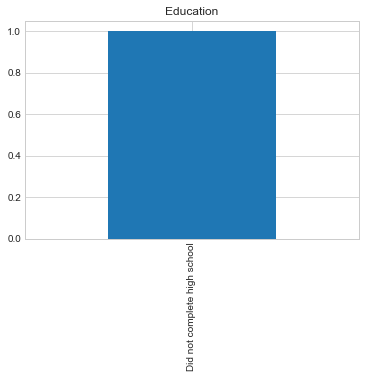

In [6]:
users.education.value_counts().plot.bar(title="Education")

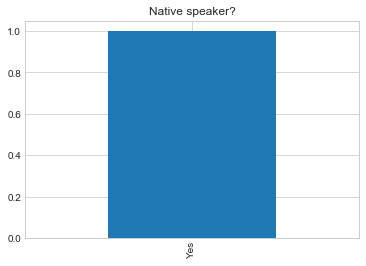

In [7]:
users.native.value_counts().plot.bar(title="Native speaker?")

In [8]:
list(users.comments.unique())

['v']

## Data prep

In [9]:
def get_candidates(trial):
    return {key: referent for key, referent in trial["referents"].items()
            if referent["reference_frame"] is not None}

In [10]:
trials_parsed = [(i, json.loads(trial.trial_data)) for i, trial in trials.iterrows()]
exp_trials = [(i, trial) for i, trial in trials_parsed if trial["trial_type"] == "scene-choice"]
exp_trials[:2]

[(4,
  {'choice': 'B',
   'frame': 'boxcar.73',
   'frame_path': 'boxcar.73.png',
   'internal_node_id': '0.0-4.0',
   'labeled_frame_path': 'boxcar.73.labeled.png',
   'prompt': "I'm looking for the pile of boxes that is near the car. Which is the pile that I'm looking for?",
   'prompt_type': 'pick',
   'referents': {'A': {'manipulations': {'location': 0.22240133310055632,
      'rotation': -0.5560627472171503},
     'name': 'box',
     'reference_frame': 'functional'},
    'B': {'manipulations': {'location': 0.5878578256865715,
      'rotation': 2.097473105277775},
     'name': 'box2',
     'reference_frame': 'relative'},
    'C': {'manipulations': {}, 'name': 'wall', 'reference_frame': None}},
   'relation': 'near',
   'rt': 4614,
   'scene': 'boxcar',
   'time_elapsed': 12406,
   'trial_index': 4,
   'trial_type': 'scene-choice'}),
 (6,
  {'choice': 'B',
   'frame': 'boxcar.114',
   'frame_path': 'boxcar.114.png',
   'internal_node_id': '0.0-6.0',
   'labeled_frame_path': 'boxcar.

Unfortunately the referents are missing their frame-of-reference labels for some reason – they didn't get properly exported from Blender.

I'll manually insert the correct referent frames based on the current data.

In [11]:
scene_types = set(trial["scene"] for i, trial in exp_trials)
scene_types

{'boxcar'}

In [12]:
frame_types = set(trial["frame"] for i, trial in exp_trials)
len(frame_types)

14

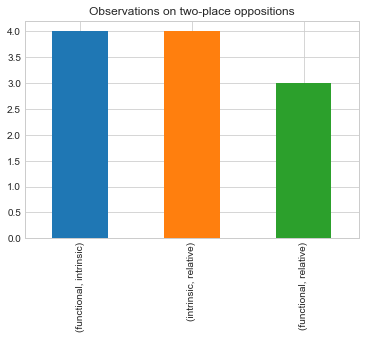

In [13]:
oppositions = [tuple(sorted(ref["reference_frame"] for ref in get_candidates(trial).values()))
               for i, trial in exp_trials
               if len(get_candidates(trial)) == 2]
pd.Series(oppositions).value_counts().plot.bar(title="Observations on two-place oppositions")

## Sanity check: filler trials

In [21]:
fillers = []
for i, trial in exp_trials:
    if trial["relation"] == "near":
        humans = get_candidates(trial)
        if trial["prompt_type"] == "count":
            fillers.append((trials.iloc[i].user_id, trial["choice"], len(humans)))
        elif trial["prompt_type"] == "pick" and len(humans) == 1:
            fillers.append((trials.iloc[i].user_id, trial["choice"], next(iter(humans.keys()))))
            
fillers = pd.DataFrame(fillers, columns=["user_id", "choice", "ground_truth"])
fillers = fillers.assign(correct=(fillers.choice == fillers.ground_truth).astype(int))
fillers.head()

,user_id,choice,ground_truth,correct


Mean accuracy on filler elements:

In [15]:
fillers["correct"].mean()

nan

Grouped by subject:

In [16]:
fillers_user_perf = fillers.groupby("user_id").correct.agg("mean")
fillers_user_perf.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: correct, dtype: float64

In [17]:
fillers_user_perf.plot.box(title="Filler accuracy per user")

TypeError: Empty 'DataFrame': no numeric data to plot

### Data filtering

Exclude outliers from the above plot.

In [22]:
fillers_mean_perf = fillers.groupby("user_id").agg("mean")
exclude_user_ids = list(fillers_mean_perf[fillers_mean_perf.correct < 0.85].index)

print("%i trials before filtering." % len(exp_trials))
exp_trials = [(i, exp_trial) for i, exp_trial in exp_trials
              if trials.iloc[i].user_id not in exclude_user_ids]
print("%i trials after filtering." % len(exp_trials))

14 trials before filtering.
14 trials after filtering.


## Sanity check: never choose non-humans

Text(0,0.5,'# users')

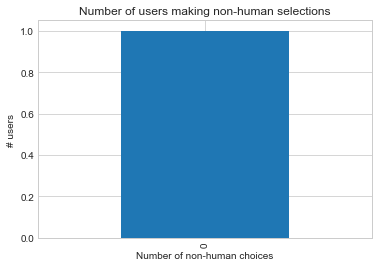

In [23]:
user_non_human_choices = {}
for i, trial in exp_trials:
    user_id = trials.iloc[i].user_id
    u_choices = user_non_human_choices.get(user_id, 0)
    
    trial_humans = get_candidates(trial)
    
    if trial["prompt_type"] == "pick":
        if trial["choice"] not in trial_humans:
            u_choices += 1
    elif trial["prompt_type"] == "count":
        if trial["choice"] > len(trial_humans):
            u_choices += 1
            
    user_non_human_choices[user_id] = u_choices
        
pd.DataFrame.from_dict(user_non_human_choices, "index")[0].value_counts().plot.bar(title="Number of users making non-human selections")
plt.xlabel("Number of non-human choices")
plt.ylabel("# users")

TODO: If people chose non-human targets, was there some logic to it?

## Reaction times

TODO: For different opposition pairs

### Overall reaction time distribution

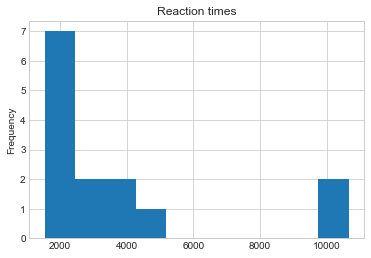

In [24]:
pd.Series([trial["rt"] for i, trial in exp_trials]).plot.hist(title="Reaction times")

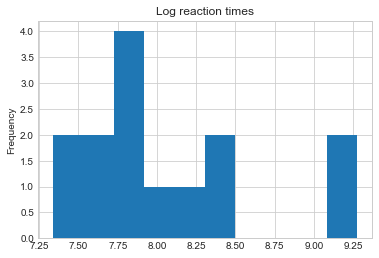

In [25]:
np.log(pd.Series([trial["rt"] for i, trial in exp_trials])).plot.hist(title="Log reaction times")

### Reaction times per scene

        count         mean          std     min      25%     50%      75%  \
boxcar   14.0  3863.357143  2979.179355  1535.0  2198.25  2517.5  4062.75   

            max  
boxcar  10671.0  


Text(0.5,0.98,'Reaction times by scene type')

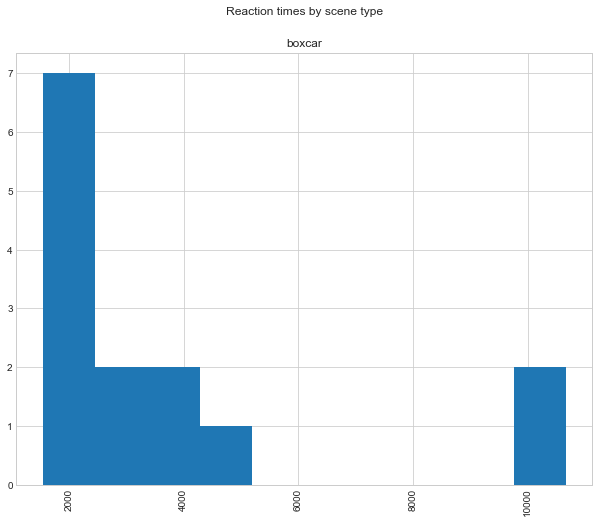

In [26]:
scene_rts = pd.DataFrame([[trial["scene"], trial["rt"]] for i, trial in exp_trials])
print(pd.DataFrame(group.describe().rename(columns={1: name}).squeeze() for name, group in scene_rts.groupby(0)))
scene_rts.hist(by=0, sharex=True, figsize=(10, 8))
plt.suptitle("Reaction times by scene type")

### Reaction times per prompt type

       count      mean       std       min       25%       50%       75%  \
count    5.0  7.665923  0.270647  7.336286  7.524021  7.633370  7.783641   
pick     9.0  8.287077  0.617738  7.672758  7.761319  8.198639  8.436850   

            max  
count  8.052296  
pick   9.275285  


Text(0.5,0.98,'Log reaction times by prompt type')

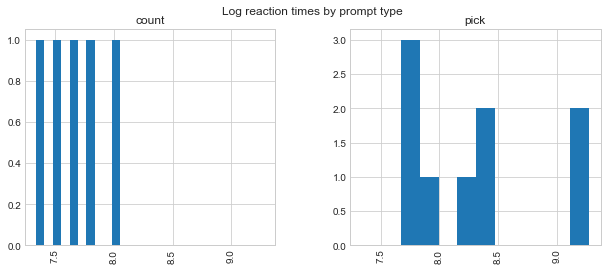

In [27]:
prompt_rts = pd.DataFrame([[trial["prompt_type"], np.log(trial["rt"])] for i, trial in exp_trials])
print(pd.DataFrame(group.describe().rename(columns={1: name}).squeeze() for name, group in prompt_rts.groupby(0)))
prompt_rts.hist(by=0, sharex=True, figsize=(10, 4))
plt.suptitle("Log reaction times by prompt type")

## *In front of*: Two-place oppositions

The first and simplest question: when two different senses come in conflict with the prompt relation "in front of", which wins?

In [28]:
senses = ["intrinsic", "relative", "functional"]

functional  intrinsic    1
            relative     2
intrinsic   relative     1
dtype: int64


(0, 1)

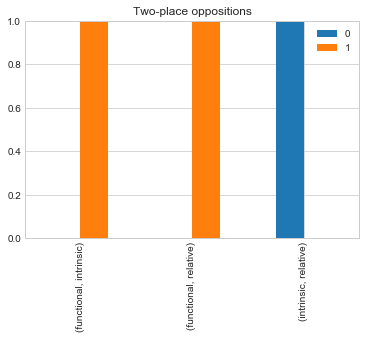

In [29]:
# For "pick" scenes, which sense wins?
def count_pick_choices(scene_type=None, target_relation="in front of"):
    opp_scenes = defaultdict(list)
    for i, trial in exp_trials:
        if trial["relation"] != target_relation:
            continue
        if scene_type is not None and scene_type != trial["scene"]:
            continue

        humans = get_candidates(trial)
        frames = [trial["referents"][key]["reference_frame"] for key in humans]
        if None not in frames and len(set(frames)) == 2:
            opp_key = tuple(sorted(frames))
            opp_scenes[opp_key].append((i, trial))
    
    opp_pick_choices = defaultdict(lambda: {0: 0, 1: 0})
    for (s1, s2), opp_trials in opp_scenes.items():
        for i, trial in opp_trials:
            if trial["prompt_type"] == "pick":
                chosen_frame = trial["referents"][trial["choice"]]["reference_frame"]
                chosen_frame_idx = 0 if chosen_frame == s1 else 1
                opp_pick_choices[s1, s2][chosen_frame_idx] += 1
    return opp_pick_choices
    
opp_pick_choices = pd.DataFrame.from_dict(count_pick_choices(), "index")
counts = opp_pick_choices.sum(axis=1)
print(counts)
opp_pick_choices = opp_pick_choices.div(opp_pick_choices.sum(axis=1), axis=0)
std_err = np.sqrt(opp_pick_choices.mul(1 - opp_pick_choices).iloc[:, 0].div(counts))
opp_pick_choices.plot.bar(title="Two-place oppositions", yerr=std_err)
plt.ylim((0, 1))

### Per scene

Let's see if the trends hold within scenes as well. (Hopefully we'll have enough data to check this!)

boxcar: observation counts
functional  intrinsic    1
            relative     2
intrinsic   relative     1
dtype: int64




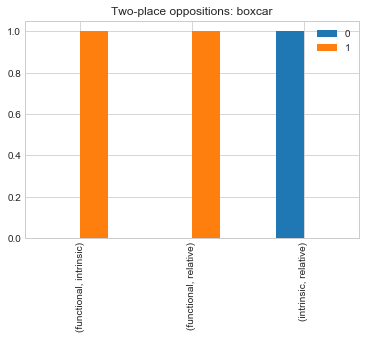

In [30]:
for scene_type in scene_types:
    scene_opp_pick_choices = pd.DataFrame.from_dict(count_pick_choices(scene_type), "index")
    print("%s: observation counts" % scene_type)
    counts = scene_opp_pick_choices.sum(axis=1)
    print(counts)
    print("\n")
    
    scene_opp_pick_choices = scene_opp_pick_choices.div(scene_opp_pick_choices.sum(axis=1), axis=0)
    std_err = np.sqrt(scene_opp_pick_choices.mul(1 - scene_opp_pick_choices).iloc[:, 0].div(counts))
    scene_opp_pick_choices.plot.bar(title="Two-place oppositions: %s" % scene_type, yerr=std_err)

High-level patterns:

- intrinsic > relative, 100%
- functional > relative in manbus, mantv but opposite trend in mancar

Not enough data on other comparisons.

- functional > intrinsic? not enough data anywhere (not even one sample for mancar :( )

## *In front of*: Counting

Let's look at scenes where multiple humans are "in front of" a ground object in different senses.

Do people consider all senses of "in front of" when counting?

- If so, we should see a pattern along $x = y$ in the scatter plot.
- If not, we should regularly see a count of 1 in the scatter plot. (There is only ever one human satisfying any single sense in a given scene.)

5 counting trials with relation 'in front of.'


(-0.15, 2.15)

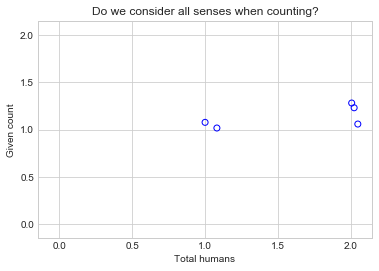

In [31]:
front_count_trials = [(i, trial) for i, trial in exp_trials
                      if trial["prompt_type"] == "count" and trial["relation"] == "in front of"]
print("%i counting trials with relation 'in front of.'" % len(front_count_trials))
# NB: jitter
plt.scatter([len(get_candidates(trial)) + np.random.random() * 0.1 for i, trial in front_count_trials],
            [trial["choice"] + np.random.random() * 0.3 for i, trial in front_count_trials],
            facecolors="none", edgecolors="blue")
plt.xlabel("Total humans")
plt.ylabel("Given count")
plt.title("Do we consider all senses when counting?")
plt.xlim((-0.15, 2.15))
plt.ylim((-0.15, 2.15))

### People selecting "0"

Interesting – some people pick "0" when there are 1 or 2 people in the scene. Which are the active senses when these counts are selected?

In [32]:
front_count_1_senses = [next(iter(get_candidates(trial).values()))["reference_frame"]
                        for i, trial in front_count_trials
                        if trial["choice"] == 0 and len(get_candidates(trial)) == 1]
pd.Series(front_count_1_senses).value_counts().plot.bar(title="Available senses when subjects picked count=0 and max count=1")

TypeError: Empty 'DataFrame': no numeric data to plot

In [33]:
front_count_2_senses = [tuple(sorted(ref["reference_frame"] for ref in get_candidates(trial).values()))
                        for i, trial in front_count_trials
                        if trial["choice"] == 0 and len(get_candidates(trial)) == 2]
pd.Series(front_count_2_senses).value_counts().plot.bar(title="Available senses when subjects picked count=0 and max count=2")

TypeError: Empty 'DataFrame': no numeric data to plot

Are there particular scenes or frames that cause people to predict counts as 0?

In [34]:
pd.Series([trial["scene"] for i, trial in front_count_trials if trial["choice"] == 0]).value_counts().plot.bar(title="count=0 predictions per scene")

TypeError: Empty 'DataFrame': no numeric data to plot

## Functional frame of reference

### How many subjects *ever* endorse a functional meaning?

Here an endorsement is

- a prediction of "1" in a count trial when the relevant candidate is in a functional frame,
- a pick of a candidate in a functional frame in either a two-place opposition or alone

An explicit rejection is

- a prediction of "0" in a count trial when the relevant candidate is in a functional frame

In [35]:
functional_endorsements = pd.DataFrame(index=trials.user_id.unique(), columns=["explicit_endorse", "explicit_reject"]).fillna(0)

for i, exp_trial in exp_trials:
    user_id = trials.iloc[i].user_id
    
    if not exp_trial["relation"] == "in front of":
        continue
        
    if exp_trial["prompt_type"] == "count":
        candidates = get_candidates(exp_trial)
        func_refs = [ref for ref in candidates.values() if ref["reference_frame"] == "functional"]
        if len(candidates) == 1 and len(func_refs) == 1:
            if exp_trial["choice"] == 1:
                functional_endorsements.loc[user_id].explicit_endorse += 1
            else:
                functional_endorsements.loc[user_id].explicit_reject += 1
    elif exp_trial["prompt_type"] == "pick":
        if exp_trial["referents"][exp_trial["choice"]]["reference_frame"] == "functional":
            functional_endorsements.loc[user_id].explicit_endorse += 1
            
functional_endorsements

,explicit_endorse,explicit_reject
debugHP1B1C:debugIQ1RBC,1,0


In [36]:
functional_endorsements.sum(axis=0)

explicit_endorse    1
explicit_reject     0
dtype: int64

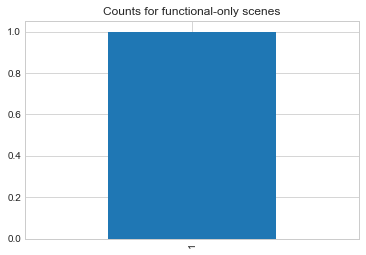

In [37]:
func_count_trials = [(i, trial) for i, trial in exp_trials
                     if trial["prompt_type"] == "count" and len(get_candidates(trial)) == 1 and next(iter(get_candidates(trial).values()))["reference_frame"] == "functional"]
pd.Series([trial["choice"] for i, trial in func_count_trials]).value_counts().plot.bar(title="Counts for functional-only scenes")

### Functional endorsements vs. angle

Text(0.5,0.98,'Is endorsement a function of model angle?')

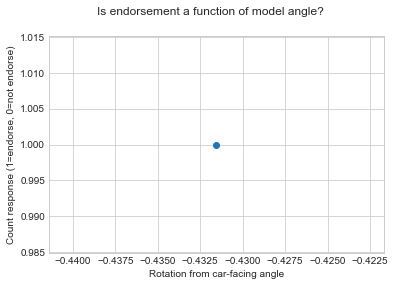

In [38]:
plt.scatter([next(iter(get_candidates(trial).values()))["manipulations"]["rotation"] for i, trial in func_count_trials],
            [trial["choice"] for i, trial in func_count_trials])
plt.xlabel("Rotation from car-facing angle")
plt.ylabel("Count response (1=endorse, 0=not endorse)")
plt.suptitle("Is endorsement a function of model angle?")

Text(0.5,0.98,'Functional picks vs. rotation angle of functional referent')

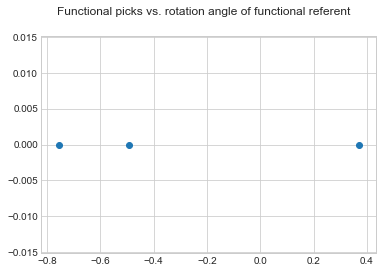

In [39]:
# Also consider two-place opp trials in which functional winds.
functional_opp_trials = [(i, exp_trial) for i, exp_trial in exp_trials
                         if len(get_candidates(exp_trial)) == 2 and exp_trial["prompt_type"] == "pick"
                             and exp_trial["relation"] == "in front of"
                             and any(ref["reference_frame"] == "functional" for ref in exp_trial["referents"].values())]
functional_opp_wins = [(i, exp_trial) for i, exp_trial in functional_opp_trials
                       if exp_trial["referents"][exp_trial["choice"]]["reference_frame"] == "functional"]

plt.scatter([next(ref for ref in trial["referents"].values() if ref["reference_frame"] == "functional")["manipulations"]["rotation"] for i, trial in functional_opp_trials],
            [1.0 if trial["referents"][trial["choice"]]["reference_frame"] == "functional" else 0.0 for i, trial in functional_opp_trials])
plt.suptitle("Functional picks vs. rotation angle of functional referent")

## Relative frame of reference

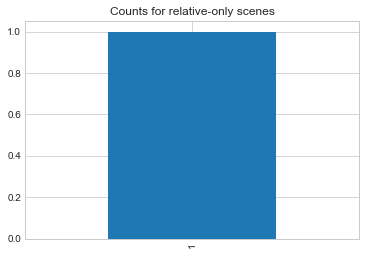

In [40]:
rel_count_trials = [(i, trial) for i, trial in exp_trials
                    if trial["prompt_type"] == "count" and len(get_candidates(trial)) == 1 and next(iter(get_candidates(trial).values()))["reference_frame"] == "relative"]
pd.Series([trial["choice"] for i, trial in rel_count_trials]).value_counts().plot.bar(title="Counts for relative-only scenes")

### Relative endorsements vs. position

Text(0.5,0.98,'Is endorsement a function of model location?')

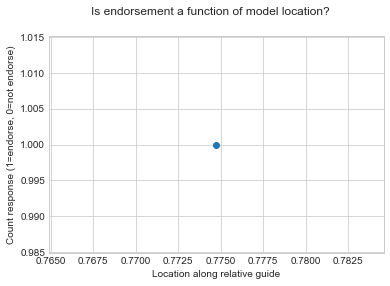

In [41]:
plt.scatter([next(iter(get_candidates(trial).values()))["manipulations"]["location"] for i, trial in rel_count_trials],
            [trial["choice"] for i, trial in rel_count_trials])
plt.xlabel("Location along relative guide")
plt.ylabel("Count response (1=endorse, 0=not endorse)")
plt.suptitle("Is endorsement a function of model location?")

## *Near*: what sense?

What sense are people using when answering "near" prompts?

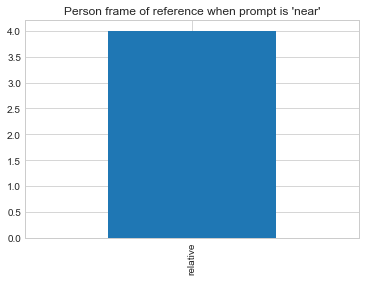

In [42]:
near_pick_trials = [(i, trial) for i, trial in exp_trials
                    if trial["prompt_type"] == "pick" and trial["relation"] == "near"]
near_pick_senses = [trial["referents"][trial["choice"]]["reference_frame"] for i, trial in near_pick_trials]
pd.Series(near_pick_senses).value_counts().plot.bar(title="Person frame of reference when prompt is 'near'")

functional  relative    1
intrinsic   relative    3
dtype: int64


(0, 1)

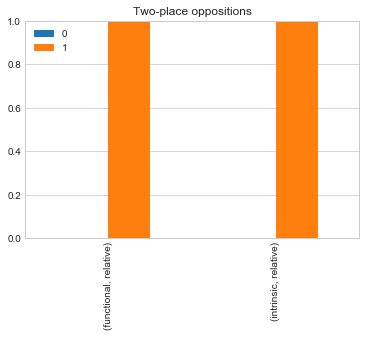

In [43]:
opp_pick_near_choices = pd.DataFrame.from_dict(count_pick_choices(target_relation="near"), "index")
counts = opp_pick_near_choices.sum(axis=1)
print(counts)
opp_pick_near_choices = opp_pick_near_choices.div(opp_pick_near_choices.sum(axis=1), axis=0)
std_err = np.sqrt(opp_pick_near_choices.mul(1 - opp_pick_near_choices).iloc[:, 0].div(counts))
opp_pick_near_choices.plot.bar(title="Two-place oppositions", yerr=std_err)
plt.ylim((0, 1))